# Prepare libraries

In [5]:
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
import logging
import matplotlib.pyplot as plt
logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# BoVW

In [36]:
class BoVW:
    """
    Bag of visual words model
    """
    def __init__(self, extractor, train_images=None, class_num=2, vocabulary_size=5):
        """
        Initialise model and possibly train on data
        Args:
            extractor: model of decsriptors extraction (SIFT for example)
            train_images: array of images
            class_num: number of images classes
            vocabulary_size: size of visual words vocabulary
        """
        self.extractor = extractor
        self.class_num = class_num
        self.vocabulary_size = vocabulary_size
        self.train_images = train_images
        self.cluster_model = KMeans(n_clusters=class_num, verbose=1)
        self.scaler = StandardScaler()
        self.train_histograms = None
        self.predictor = None
        
        # Train models if train data is available
        if self.train_images is not None:
            print("Training BoVW starts ...")
            print("Extracting descriptors ...")
            train_desc = self._get_images_descriptors(self.train_images)
            print("Grouping descriptors ...")
            all_descriptors_list = self._get_descriptors_list(train_desc)
            print("Descriptors extracted from tarin images")
            print("Training cluster model ...")
            self._train_cluster_model(all_descriptors_list,vocabulary_size)
            print("Cluster model trained")
            print("Computing histograms ...")
            train_histograms = self._get_histograms(train_desc)
            print("Histograms computed")
            print("Normalizing histograms ...")
            self.scaler.fit(train_histograms)  
            self.train_histograms = self.scaler.transform(train_histograms)
            print("Histograms normalized")
            
            
    
    def _get_image_descriptors(self,image):
        """
        Extract image descriptors from image
        Args:
            image: image to extract descriptors from
        Return:
            keypoints, descriptors extracted from image
        """
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return keypoints, descriptors
    
    
    def _get_images_descriptors(self,images):
        """
        Extract image descriptors from array of images
        Args:
            images: array of images to extract descriptors from
        Returns:
            array of extracted descriptors, 1 item for 1 image
        """
        descriptors = []
        
        for image in tqdm(images):
            _, img_features = self._get_image_descriptors(image)
            if img_features is not None:
                descriptors.append(img_features)
        return np.array(descriptors)
        
    def _get_descriptors_list(self, descriptors):
        """
        Stack descriptors in array of shape (n, 128)
        Args:
            descriptors: array of extracted descriptors
        Returns:
            descriptors in array of shape (n, 128)
        """
        stacked_descriptors = np.array(descriptors[0])
        for descriptor in tqdm(descriptors[1:]):
            if descriptor is not None:
                stacked_descriptors = np.vstack((stacked_descriptors, descriptor))
        
        return stacked_descriptors
        
    
    def _train_cluster_model(self, descriptors, cluster_num=2):
        """
        Train K-Means with extracted descriptors to form vocabulary
        Args:
            descriptors: descriptors in array of shape (n, 128)
            cluster_num: Number of visual words in vocabulary
        """
        self.cluster_model = KMeans(n_clusters=cluster_num, verbose=1, init='random', n_init=1).fit(descriptors)
    
    
    def _get_histograms(self, descriptors):
        """
        Produce vocabulary histograms from list of image descriptors
        Args:
            descriptors: array of descriptors extracted from images
        Returns:
            Vocabulary histograms, 1 per image
        """
        histograms = np.zeros((descriptors.shape[0], self.vocabulary_size))
        
        for i in tqdm(range(descriptors.shape[0])):
            for j in range(len(descriptors[i])):
                feature = descriptors[i][j]
                feature = feature.reshape(1, 128)
                idx = self.cluster_model.predict(feature)
                histograms[i][idx] += 1
        return histograms

                
    def plot_histogram(self, histograms):
        """
        Ptot historams
        """
        x_scalar = np.arange(self.class_num)
        y_scalar = np.array([abs(np.sum(histograms[:,h], dtype=np.int32)) for h in range(self.class_num)])

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()
        
    def plot_nearest_neighbours(self, neighbour_ids, distances=None):
        """
        Plot images in row by their ids
        """
        count = len(neighbour_ids)
        plt.figure(figsize=(20,10))
        for i in range(len(neighbour_ids)):
            idx = neighbour_ids[i]
            subplot = plt.subplot(1, count, i+1)
            if distances is not None:
                subplot.set_title("{:10.4f}".format(distances[i]))
      
            img = self.train_images[idx]
            cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
            subplot.imshow(img, cmap=cmap)
        plt.show()
        
        
    def get_neares_neighbours(self, image, n_neighbours=10):
        """
        Extract nearest neighbours from train dataset for new image with KNN
        Args:
            image: Querry image
            n_neighbours: number of neighbours to retrieve
        Returns:
            2 arrays: distances and ids of neighbours
        """
        
        _, descriptor = self._get_image_descriptors(image)
        descriptors = np.array([descriptor])
        
        histograms = self._get_histograms(descriptors)
        histogram = self.scaler.transform(histograms)[0]
        
        knn = NearestNeighbors(n_neighbors=n_neighbours)
        knn.fit(self.train_histograms)
        return knn.kneighbors([histogram])
        

# Test on MNIST

### Upload data

In [53]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

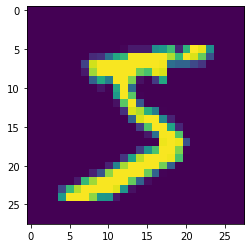

In [54]:
plt.imshow(x_train[0])
plt.show()

### Train BoVW

In [55]:
bovw = BoVW(extractor=cv2.xfeatures2d.SIFT_create(), train_images=x_train[:10000], class_num=10, vocabulary_size=1000)

  2%|▏         | 174/10000 [00:00<00:05, 1734.22it/s]

Training BoVW starts ...
Extracting descriptors ...


  9%|▉         | 873/9768 [00:00<00:01, 8727.49it/s]

Grouping descriptors ...


100%|██████████| 9768/9768 [00:16<00:00, 581.98it/s] 


Descriptors extracted from tarin images
Training cluster model ...
Initialization complete
Iteration 0, inertia 3610516736.0
Iteration 1, inertia 2511572736.0
Iteration 2, inertia 2396959232.0
Iteration 3, inertia 2349979648.0
Iteration 4, inertia 2324339968.0
Iteration 5, inertia 2308163584.0
Iteration 6, inertia 2296966656.0
Iteration 7, inertia 2288706304.0
Iteration 8, inertia 2282542848.0
Iteration 9, inertia 2277574400.0
Iteration 10, inertia 2273559808.0
Iteration 11, inertia 2270080768.0
Iteration 12, inertia 2267186176.0
Iteration 13, inertia 2264807168.0
Iteration 14, inertia 2262723328.0
Iteration 15, inertia 2260902912.0
Iteration 16, inertia 2259443200.0
Iteration 17, inertia 2258318848.0
Iteration 18, inertia 2257380352.0
Iteration 19, inertia 2256584448.0
Iteration 20, inertia 2255879680.0
Iteration 21, inertia 2255253248.0
Iteration 22, inertia 2254701312.0
Iteration 23, inertia 2254227200.0
Iteration 24, inertia 2253841664.0
Iteration 25, inertia 2253506560.0
Iteration

  0%|          | 25/9769 [00:00<00:40, 239.86it/s]

Iteration 75, inertia 2250075648.0
Converged at iteration 75: strict convergence.
Cluster model trained
Computing histograms ...


100%|██████████| 9769/9769 [00:29<00:00, 333.07it/s]


Histograms computed
Normalizing histograms ...
Histograms normalized


### Retrieve neares neighbours

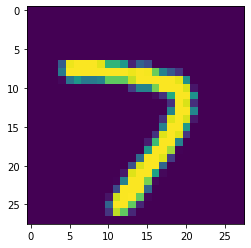

100%|██████████| 1/1 [00:00<00:00, 183.37it/s]


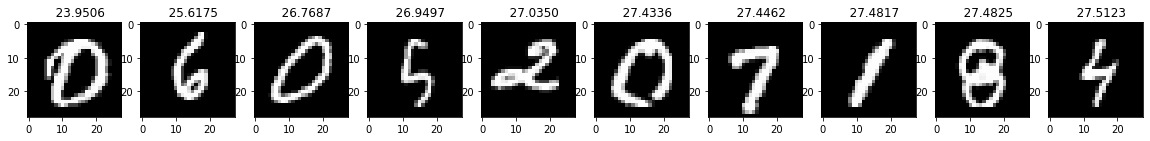

In [57]:
test_img = x_test[17]
plt.imshow(test_img)
plt.show()
dists, ids = bovw.get_neares_neighbours(test_img, n_neighbours=10)
bovw.plot_nearest_neighbours(ids[0], dists[0])

# Test on CIFAR-10

### Upload data

In [58]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


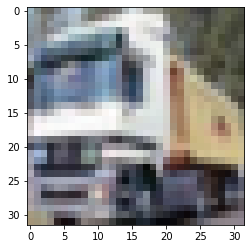

In [59]:
plt.imshow(train_images[1])
plt.show()

### Train BoVW

In [60]:
bovw2 = BoVW(extractor=cv2.xfeatures2d.SIFT_create(), train_images=train_images[:10000], class_num=10, vocabulary_size=1000)

  1%|▏         | 143/10000 [00:00<00:06, 1424.27it/s]

Training BoVW starts ...
Extracting descriptors ...


  6%|▌         | 612/9974 [00:00<00:01, 6117.09it/s]

Grouping descriptors ...


100%|██████████| 9974/9974 [00:28<00:00, 345.06it/s] 


Descriptors extracted from tarin images
Training cluster model ...
Initialization complete
Iteration 0, inertia 13820966912.0
Iteration 1, inertia 9703944192.0
Iteration 2, inertia 9430820864.0
Iteration 3, inertia 9314598912.0
Iteration 4, inertia 9247831040.0
Iteration 5, inertia 9203658752.0
Iteration 6, inertia 9172329472.0
Iteration 7, inertia 9149313024.0
Iteration 8, inertia 9131151360.0
Iteration 9, inertia 9117187072.0
Iteration 10, inertia 9106165760.0
Iteration 11, inertia 9097500672.0
Iteration 12, inertia 9090588672.0
Iteration 13, inertia 9084437504.0
Iteration 14, inertia 9079377920.0
Iteration 15, inertia 9074998272.0
Iteration 16, inertia 9071112192.0
Iteration 17, inertia 9067466752.0
Iteration 18, inertia 9064190976.0
Iteration 19, inertia 9061260288.0
Iteration 20, inertia 9058749440.0
Iteration 21, inertia 9056634880.0
Iteration 22, inertia 9054512128.0
Iteration 23, inertia 9052612608.0
Iteration 24, inertia 9051128832.0
Iteration 25, inertia 9049566208.0
Iteratio

  0%|          | 12/9975 [00:00<01:29, 111.65it/s]

Iteration 103, inertia 9028424704.0
Converged at iteration 103: strict convergence.
Cluster model trained
Computing histograms ...


100%|██████████| 9975/9975 [00:47<00:00, 212.07it/s]


Histograms computed
Normalizing histograms ...
Histograms normalized


### Retrieve neares neighbours

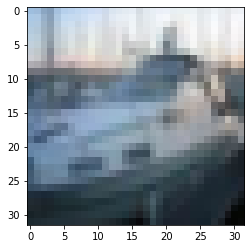

100%|██████████| 1/1 [00:00<00:00, 251.62it/s]


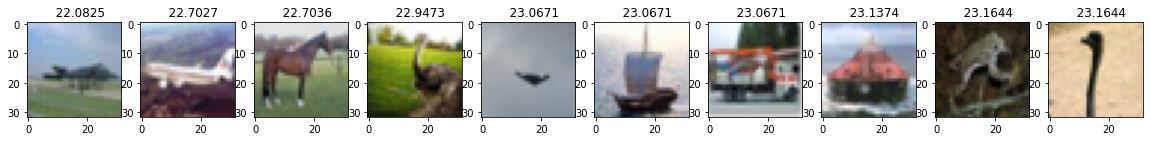

In [63]:
test_img = test_images[2]
plt.imshow(test_img)
plt.show()
dists, ids = bovw2.get_neares_neighbours(test_img, n_neighbours=10)
bovw2.plot_nearest_neighbours(ids[0], dists[0])

# Test on horses and humans (images of better quality)

### Load test data

In [7]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip  -O /tmp/horse-or-human.zip

--2020-09-16 10:37:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.210.176, 216.58.209.176, 216.58.209.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.210.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142,65M  5,52MB/s    in 25s     

2020-09-16 10:37:57 (5,80 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [8]:
import os
import zipfile
 
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

total training horse images: 500
total training human images: 527


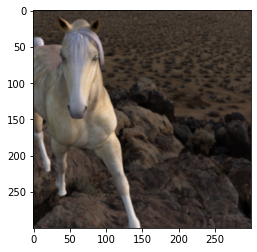

In [32]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
 
# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

train_imgs = [cv2.imread(os.path.join(os.path.join(train_horse_dir, fname))) for fname in train_horse_names]
train_imgs += [cv2.imread(os.path.join(os.path.join(train_human_dir, fname))) for fname in train_human_names]
train_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_imgs]

plt.imshow(train_imgs[3])
plt.show()

### Train model

In [37]:
bovw3 = BoVW(extractor=cv2.xfeatures2d.SIFT_create(), train_images=train_imgs, class_num=2, vocabulary_size=1000)

  0%|          | 5/1027 [00:00<00:21, 46.78it/s]

Training BoVW starts ...
Extracting descriptors ...


  8%|▊         | 85/1026 [00:00<00:01, 843.15it/s]

Grouping descriptors ...


100%|██████████| 1026/1026 [00:24<00:00, 42.56it/s]


Descriptors extracted from tarin images
Training cluster model ...
Initialization complete
Iteration 0, inertia 45607866368.0
Iteration 1, inertia 32065280000.0
Iteration 2, inertia 31126394880.0
Iteration 3, inertia 30714144768.0
Iteration 4, inertia 30484451328.0
Iteration 5, inertia 30336847872.0
Iteration 6, inertia 30231308288.0
Iteration 7, inertia 30150848512.0
Iteration 8, inertia 30088296448.0
Iteration 9, inertia 30037344256.0
Iteration 10, inertia 29995554816.0
Iteration 11, inertia 29959720960.0
Iteration 12, inertia 29929623552.0
Iteration 13, inertia 29905448960.0
Iteration 14, inertia 29885114368.0
Iteration 15, inertia 29866563584.0
Iteration 16, inertia 29849948160.0
Iteration 17, inertia 29836650496.0
Iteration 18, inertia 29824872448.0
Iteration 19, inertia 29814231040.0
Iteration 20, inertia 29804877824.0
Iteration 21, inertia 29796694016.0
Iteration 22, inertia 29788000256.0
Iteration 23, inertia 29781002240.0
Iteration 24, inertia 29774020608.0
Iteration 25, inert

  0%|          | 0/1027 [00:00<?, ?it/s]

Iteration 220, inertia 29654122496.0
Converged at iteration 220: strict convergence.
Cluster model trained
Computing histograms ...


100%|██████████| 1027/1027 [02:45<00:00,  6.20it/s]

Histograms computed
Normalizing histograms ...
Histograms normalized


### Test on random image of horse

In [51]:
!wget -O test_horse.jpg https://i0.wp.com/www.horsetalk.co.nz/wp-content/uploads/2016/08/shiny-coat-stock.jpg

--2020-09-16 11:28:51--  https://i0.wp.com/www.horsetalk.co.nz/wp-content/uploads/2016/08/shiny-coat-stock.jpg
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90348 (88K) [image/jpeg]
Saving to: ‘test_horse.jpg’

test_horse.jpg      100%[===================>]  88,23K  --.-KB/s    in 0,1s    

2020-09-16 11:28:51 (644 KB/s) - ‘test_horse.jpg’ saved [90348/90348]



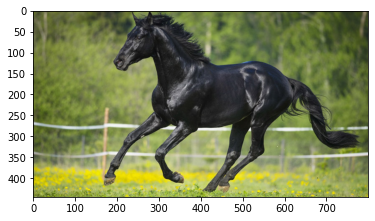

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


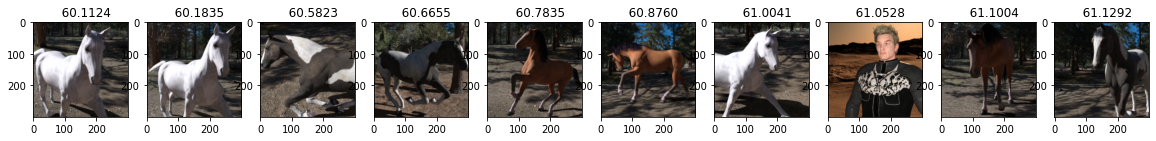

In [52]:
test_img = cv2.imread("test_horse.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()
dists, ids = bovw3.get_neares_neighbours(test_img, n_neighbours=10)
bovw3.plot_nearest_neighbours(ids[0], dists[0])

### Test on random image of human

In [64]:
!wget -O test_human.jpg https://image.freepik.com/free-photo/full-height-asian-girl-straw-hat-gray-background_231208-2197.jpg

--2020-09-16 11:40:10--  https://image.freepik.com/free-photo/full-height-asian-girl-straw-hat-gray-background_231208-2197.jpg
Resolving image.freepik.com (image.freepik.com)... 92.122.109.251, 2a02:2d8:3:990::30ec, 2a02:2d8:3:993::30ec
Connecting to image.freepik.com (image.freepik.com)|92.122.109.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59157 (58K) [image/jpeg]
Saving to: ‘test_human.jpg’

test_human.jpg      100%[===================>]  57,77K  --.-KB/s    in 0,04s   

2020-09-16 11:40:10 (1,45 MB/s) - ‘test_human.jpg’ saved [59157/59157]



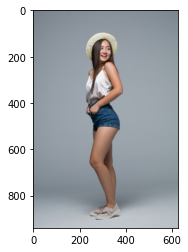

100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


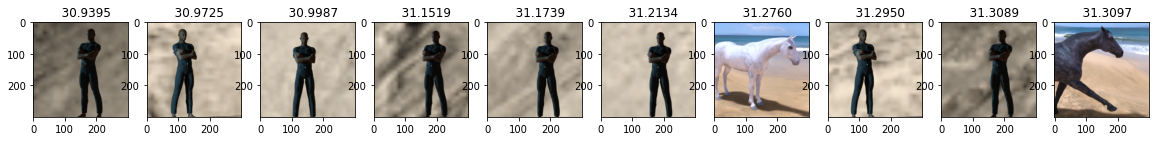

In [65]:
test_img = cv2.imread("test_human.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()
dists, ids = bovw3.get_neares_neighbours(test_img, n_neighbours=10)
bovw3.plot_nearest_neighbours(ids[0], dists[0])